In [63]:
import classla
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import json
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from ipywidgets import IntProgress
from transformers import AutoTokenizer, AutoModelForMaskedLM
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import datetime

In [2]:
tokenizer = AutoTokenizer.from_pretrained("EMBEDDIA/sloberta")

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/andrejkronovsek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# download standard models for Slovenian
classla.download('sl')
nlp = classla.Pipeline('sl', processors='tokenize,ner,pos,lemma,depparse')

2022-05-24 20:57:55 INFO: Downloading these customized packages for language: sl (Slovenian)...
| Processor | Package  |
------------------------
| tokenize  | standard |
| pos       | standard |
| lemma     | standard |
| depparse  | standard |
| ner       | standard |
| pretrain  | standard |

2022-05-24 20:57:57 INFO: File exists: /home/andrejkronovsek/classla_resources/sl/pos/standard.pt.
2022-05-24 20:57:57 INFO: File exists: /home/andrejkronovsek/classla_resources/sl/lemma/standard.pt.
2022-05-24 20:57:57 INFO: File exists: /home/andrejkronovsek/classla_resources/sl/depparse/standard.pt.
2022-05-24 20:57:57 INFO: File exists: /home/andrejkronovsek/classla_resources/sl/ner/standard.pt.
2022-05-24 20:57:58 INFO: File exists: /home/andrejkronovsek/classla_resources/sl/pretrain/standard.pt.
2022-05-24 20:57:58 INFO: Finished downloading models and saved to /home/andrejkronovsek/classla_resources.
2022-05-24 20:57:58 INFO: Loading these models for language: sl (Slovenian):
| Processor

In [5]:
stopwords = set(stopwords.words('slovene'))
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
for p in punc:
    stopwords.add(p)

In [6]:
with open("../../data/data.json", "r") as f:
    data = json.loads(f.read())

In [7]:
content = []
for article in data:
    content.append(article["title"] + " " + article["subtitle"] + " " + article["headline"])

In [8]:
len(content[:20])

20

In [18]:
lemma_all = []
for doc in content[:20]:
    lemma = [i for i in nlp(doc).get("lemma") if i not in stopwords]
    lemma_all.append(lemma)

In [19]:
with open("lemma.json", "r") as f:
    lemma_all = json.loads(f.read())

In [21]:
tagged_data = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(lemma_all)]

In [22]:
max_epochs = 100
vec_size = 5
alpha = 0.025

model = Doc2Vec(vector_size=vec_size, alpha=alpha,  min_alpha=0.00025, min_count=1, dm=1)
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v_02.model")
print("Model Saved")

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration

In [55]:
model= Doc2Vec.load("d2v.model")

# to find most similar doc using tags
similar_doc = model.dv.distances("1")
print(similar_doc)

# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
print(model.dv['100'])

[0.17422265 0.         1.236819   ... 1.0871044  0.94702226 1.0810812 ]
[ -2.2657537   7.6629596   8.755312   -1.1420728 -14.300156 ]


In [76]:
similar_doc = model.dv.distances("1")

In [27]:
titles = []
for article in data:
    titles.append(article["title"])

In [54]:
print(titles[100])
print("--------------------------")
for id, similarity in similar_doc:
    print(similarity, titles[int(id)])

Suvereni zmagi ZDA in Kanade
--------------------------
0.9916472434997559 Odbojkarji v Ligi narodov najprej proti Američanom
0.9909989833831787 Đoković odpovedal ameriško turnejo
0.9900294542312622 V Velikovcu odkrili spominsko ploščo padlim v koroških bojih
0.9879534840583801 Čehi v tekmi preobratov ugnali Ruse s 6:5
0.9867184162139893 Poraz Kraljev, Crosby zabil 500. gol
0.9859047532081604 Avstralija svari Kanyeja Westa: Necepljenim vstop v državo ni dovoljen. Ne glede na to, kdo si.
0.9855058193206787 Nika Barić iz Rusije v Turčijo
0.9852278828620911 Krimovke brez težav premagale najslabše moštvo v skupini
0.9847994446754456 Arizona po porazu s Kralji zadnja v ligi
0.9846429824829102 Kopitar s tremi podajami ob preobratu proti zadnji Arizoni


In [41]:
vectors = []
for i in range(len(titles)):
    vectors.append(model.dv[str(i)])
np.array(vectors)

array([[ -5.9046116,  13.179378 ,   5.3790016,  -2.11712  ,   4.9323764],
       [ -1.3162087,   4.827221 ,   4.7891307,  -1.3558507,   7.129795 ],
       [  4.1281786,  10.8353615,  -5.4564576,  -7.8038425, -10.494016 ],
       ...,
       [ 16.904793 ,   3.2110507,  -3.0636005,  -4.5447364,  -0.0730581],
       [ -2.4866803,  14.419546 ,   6.791834 ,   1.7108026, -12.912988 ],
       [ 10.281287 ,  -7.1956286,   7.37295  ,  -8.873397 ,  -1.8259819]],
      dtype=float32)

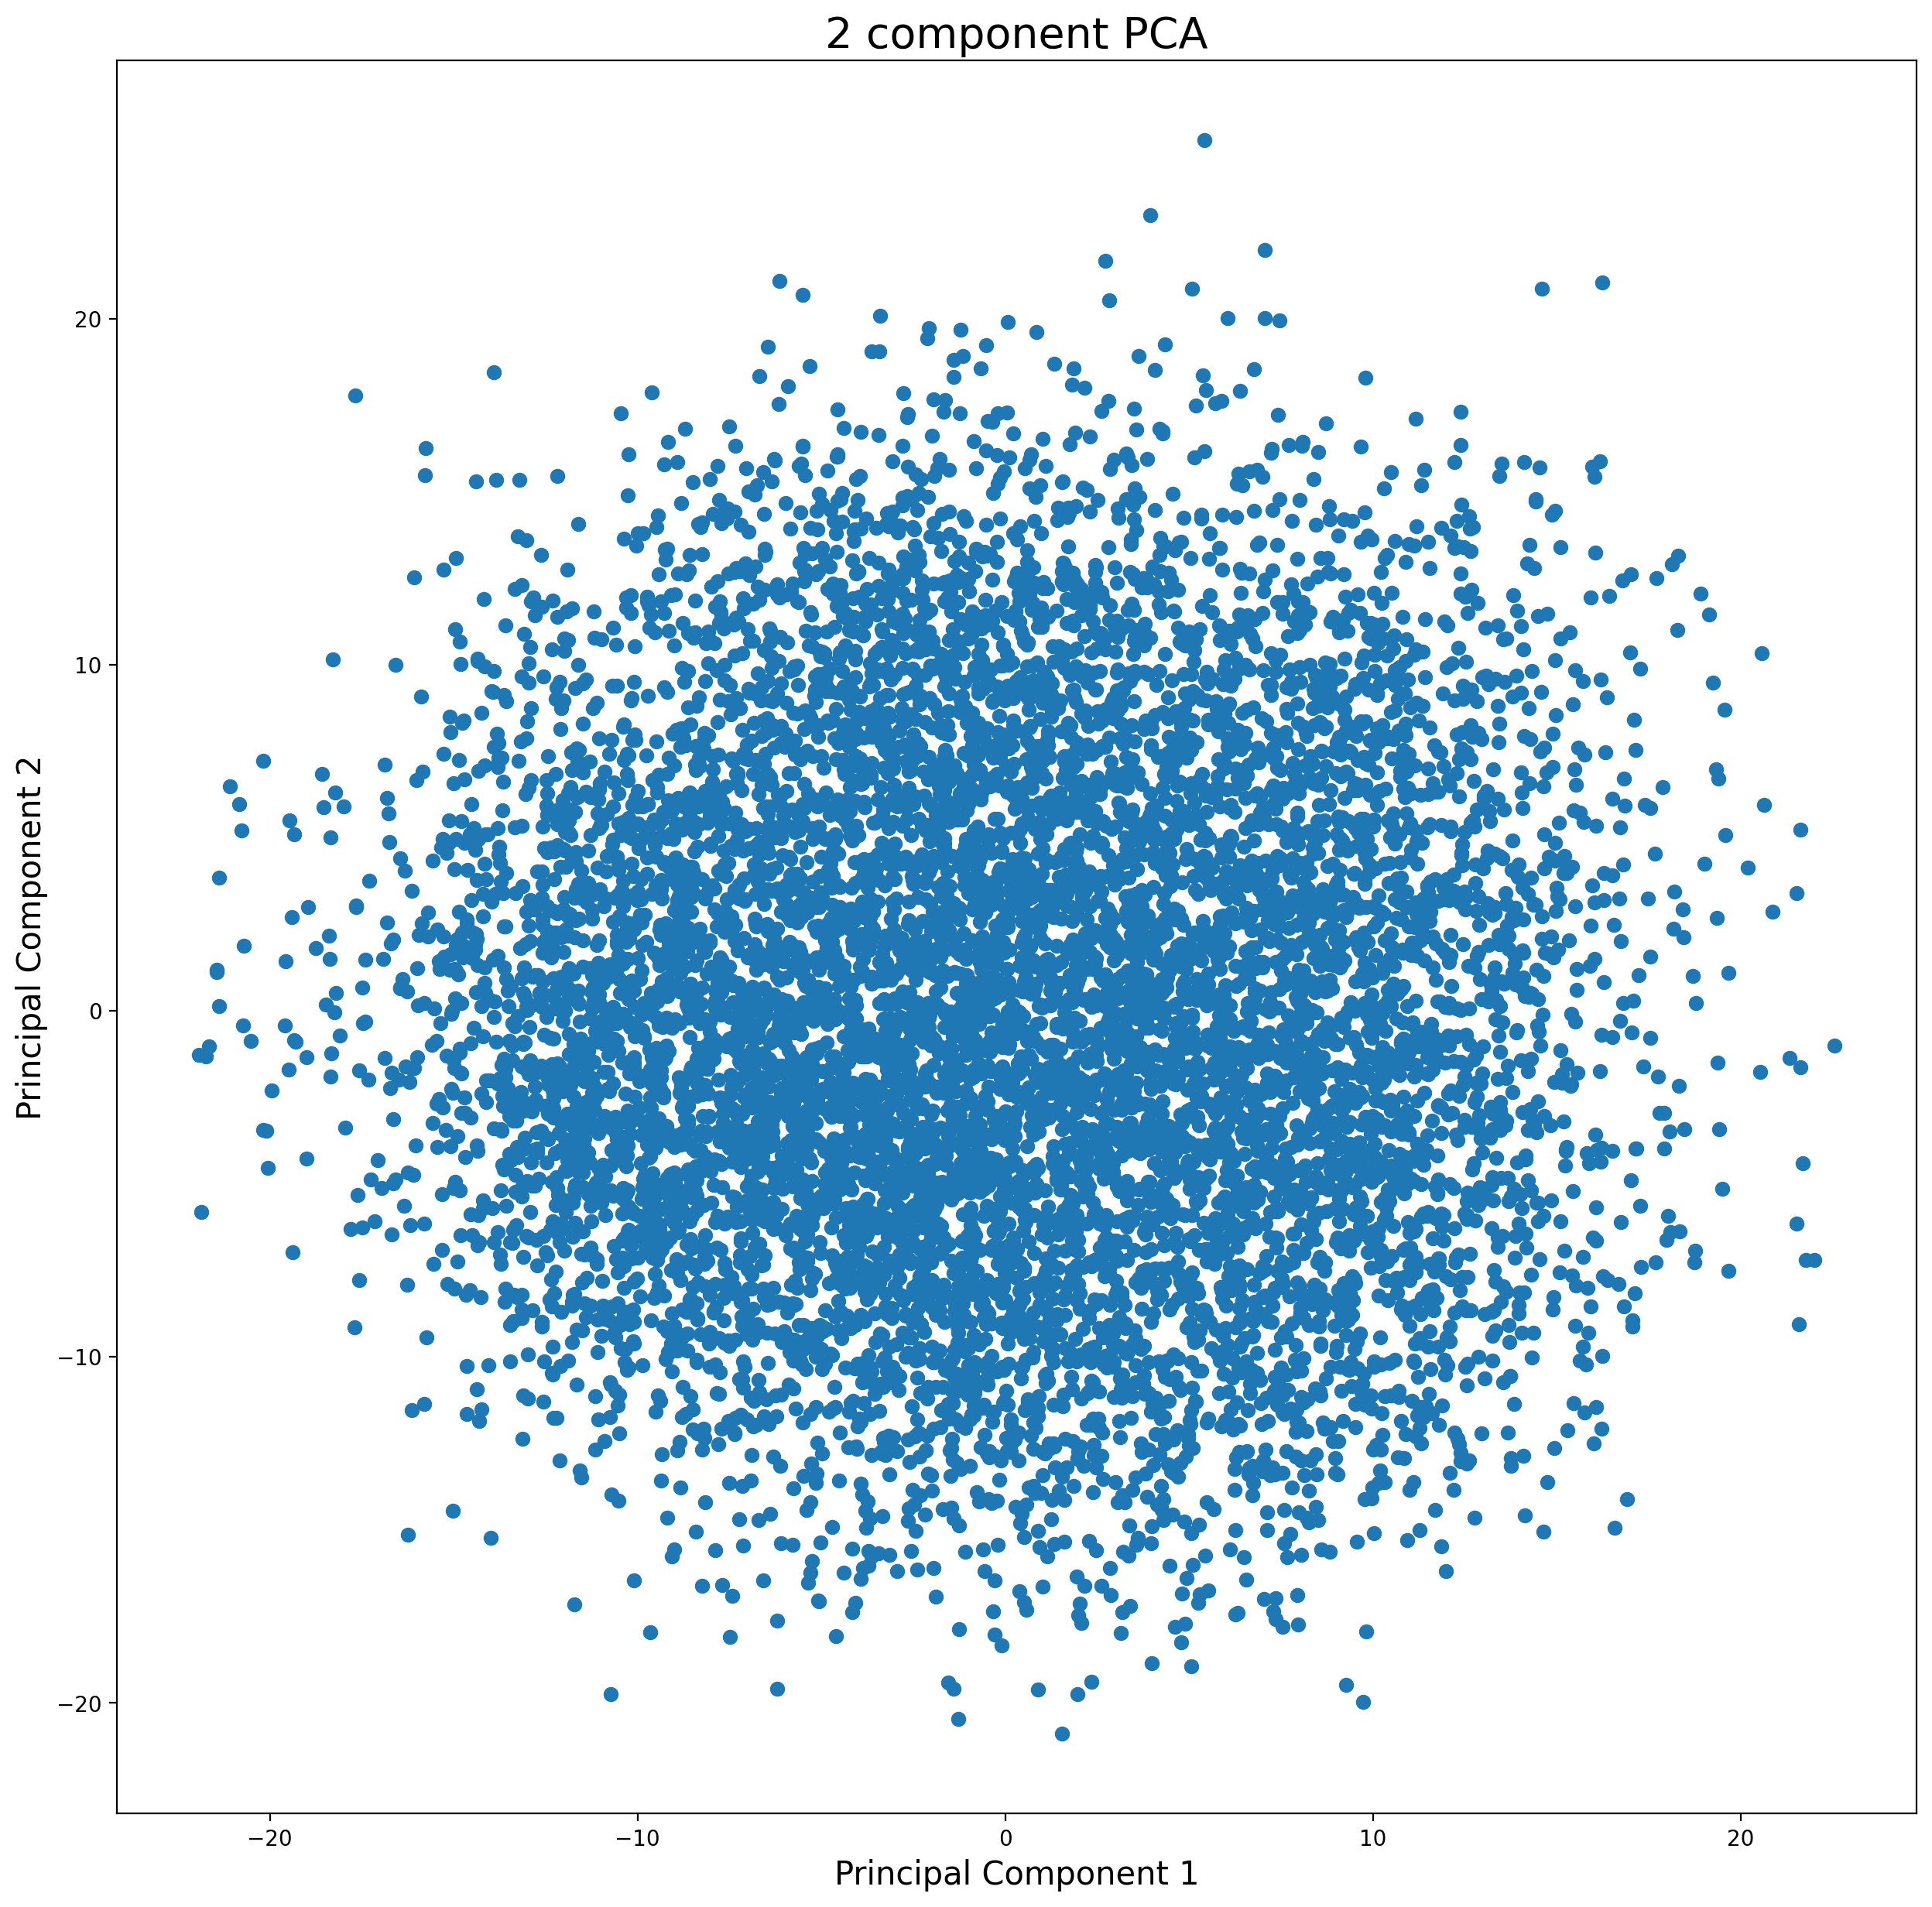

In [60]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(vectors)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

fig = plt.figure(figsize = (15,15), facecolor="white", dpi=200)
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'])

In [61]:
data_df = pd.DataFrame.from_dict(data)
data_df["datetime_published"] = pd.to_datetime(data_df['datetime_published'], format='%Y-%m-%d %H:%M:%S')

In [85]:
for idx, article in enumerate(data):
       date = datetime.datetime.strptime(article["datetime_published"], "%Y-%m-%d %H:%M:%S")
       window_start = date - datetime.timedelta(days=5)
       window_end = date + datetime.timedelta(days=5)

       data_in_window = data_df[data_df["datetime_published"] > window_start]
       data_in_window = data_in_window[data_in_window["datetime_published"] < window_end]

       distances_doc = model.dv.distances(str(idx))
       distances = dict()
       for i, row in data_in_window.iterrows():
              distances[i] = distances_doc[i]
       
       break

In [88]:
dict(sorted(distances.items(), key=lambda item: item[1]))

{0: -1.1920929e-07,
 2559: 0.02789706,
 4213: 0.061427414,
 6483: 0.070771575,
 8468: 0.11102998,
 3138: 0.12421805,
 7586: 0.180875,
 6524: 0.20824194,
 2349: 0.22406143,
 4532: 0.27890205,
 303: 0.30732894,
 7370: 0.32937843,
 528: 0.33253396,
 4971: 0.3603887,
 6030: 0.37202048,
 1955: 0.37609774,
 6760: 0.40770507,
 784: 0.40920335,
 2818: 0.42077875,
 3514: 0.43883848,
 5537: 0.44568443,
 6105: 0.51912117,
 223: 0.5487131,
 204: 0.57792544,
 7724: 0.6147324,
 2524: 0.624516,
 6192: 0.65566766,
 1790: 0.7042763,
 6226: 0.7322587,
 2097: 0.75997984,
 8008: 0.7685759,
 4550: 0.772936,
 3459: 0.8132988,
 1470: 0.82561564,
 8779: 0.8678771,
 9046: 0.8719501,
 549: 0.9659334,
 2633: 0.9767706,
 93: 0.9787239,
 5213: 0.9838142,
 2572: 1.0930213,
 5314: 1.1778316,
 2809: 1.1883888,
 2621: 1.2196563,
 230: 1.3674548}